# Fitting Neural Net
We fit a Neural Net to the Sepsis data in this note

In [1]:
import pandas as pd
import numpy as np
exportdir='/data/localhost/taufiq/export-dir/'

In [2]:
import logging
logging.basicConfig(filename='neural-net.log', level=logging.INFO)

In [3]:
nra = 5

## Import Data

In [4]:
MIMICraw = pd.read_csv(exportdir + 'MIMICraw-logistic_reg.csv')
MIMICraw.head()

,gender,mechvent,re_admission,age,Weight_kg,GCS,HR,SysBP,MeanBP,DiaBP,...,Creatinine,SGOT,SGPT,Total_bili,INR,output_total,output_4hourly,last_input,total_input_before,last_vaso_dose
0,-0.5,-0.5,-0.5,-1.051213,1.827456,-0.952846,-0.523975,-0.064338,0.296909,0.475162,...,0.735987,0.250377,-0.38494,3.417208,0.302317,0.074017,0.612008,-1.227250,-1.967244,-0.5
1,-0.5,-0.5,-0.5,-1.051213,-0.135125,-0.952846,-0.445075,-0.441478,0.000394,0.195434,...,-0.730676,-0.171064,-0.38494,1.549167,-0.961687,0.182853,0.590004,0.287835,0.627278,-0.5
2,-0.5,-0.5,-0.5,-1.051213,-0.135125,-0.899877,-0.521990,-0.806252,-0.147864,0.182833,...,-0.730676,-0.171064,-0.38494,1.549167,-0.245226,0.248674,0.531440,0.423093,0.629135,-0.5
3,-0.5,-0.5,-0.5,-1.051213,-0.135125,-0.635036,-0.705596,0.059314,1.334712,1.745278,...,-0.730676,-0.171064,-0.38494,1.549167,-0.961687,0.294020,0.480217,0.423093,0.630978,-0.5
4,-0.5,-0.5,-0.5,-1.051213,-0.135125,0.381956,0.690797,0.534139,1.527447,1.767959,...,-0.730676,-0.171064,-0.38494,1.549167,-0.961687,0.328069,0.438177,0.423093,0.632806,-0.5


In [5]:
MIMICtable = pd.read_csv(exportdir + 'MIMICtable.csv')
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance
0,1.0,3.0,7.245400e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.653782,222.499997,0.0,0.0,6297.0,30.0,9090.0,4305.0,-2793.0
1,2.0,3.0,7.245414e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.710438,207.499997,0.0,0.0,6347.0,50.0,13060.0,3970.0,-6713.0
2,3.0,3.0,7.245428e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.748397,207.499997,0.0,0.0,6397.0,50.0,16260.0,3200.0,-9863.0
3,4.0,3.0,7.245443e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.615226,207.499997,0.0,0.0,6447.0,50.0,18910.0,2650.0,-12463.0
4,5.0,3.0,7.245457e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.749047,165.573772,0.0,0.0,6477.0,30.0,21180.0,2270.0,-14703.0


## Create Actions

In [6]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_4hourly_nonzero = MIMICtable.loc[MIMICtable['input_4hourly']>0, 'input_4hourly']
iol_ranked = rankdata(input_4hourly_nonzero)/len(input_4hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_4hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_4hourly'].median(), MIMICtable.loc[io==2, 'input_4hourly'].median(), MIMICtable.loc[io==3, 'input_4hourly'].median(), MIMICtable.loc[io==4, 'input_4hourly'].median(), MIMICtable.loc[io==5, 'input_4hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

## Create Training and Test data

In [26]:
icuuniqueids = MIMICtable['icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = MIMICraw.loc[MIMICtable['icustay_id'].isin(trainidx)]
Xtestmimic = MIMICraw[MIMICtable['icustay_id'].isin(testidx)]
blocs = MIMICtable.loc[MIMICtable['icustay_id'].isin(trainidx), 'bloc']
bloctestmimic = MIMICtable.loc[MIMICtable['icustay_id'].isin(testidx), 'bloc']
ptid = MIMICtable.loc[MIMICtable['icustay_id'].isin(trainidx), 'icustay_id']
ptidtestmimic = MIMICtable.loc[MIMICtable['icustay_id'].isin(testidx), 'icustay_id']
Y = actionbloc.loc[MIMICtable['icustay_id'].isin(trainidx), 'action_bloc']
Ytest = actionbloc.loc[MIMICtable['icustay_id'].isin(testidx), 'action_bloc']


## Define the Neural Network Architecture

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(47, 50)
        self.lin2 = nn.Linear(50, 50)
        self.lin3 = nn.Linear(50, nact)

    def forward(self, xb):
        xb = F.relu(self.lin1(xb))
        xb = F.relu(self.lin2(xb))
        xb = F.softmax(self.lin3(xb), dim=1)
        return xb
    

loss_func = F.cross_entropy        

In [28]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [29]:
X, Y, Xtestmimic, Ytest = map(torch.tensor, (X.values, Y.values, Xtestmimic.values, Ytest.values))

In [30]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_ds = TensorDataset(X, Y)
train_dl = DataLoader(train_ds, batch_size=32)

test_ds = TensorDataset(Xtestmimic, Ytest)
test_dl = DataLoader(test_ds, batch_size=32*2)


## Training

In [39]:
def accuracy(dataloader):
    global model
    matches = 0
    for xb, yb in dataloader:
        _, predicted = torch.max(model(xb.float()), 1)
        matches += (predicted == yb).sum()
    return (matches.float()/len(dataloader.dataset)).item()

In [40]:
model, opt = get_model()
test_loss = []
test_acc = []
train_acc = []
logging.info('Starting training')

for epoch in range(1000):
    logging.info('Epoch: ' + str(epoch))
    model.train()
    for xb, yb in train_dl:
        pred = model(xb.float())
        loss = loss_func(pred, yb.long())

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb.float()), yb.long()) for xb, yb in test_dl)
        test_loss.append(valid_loss)
        if epoch % 50 == 0:
            test_acc.append(accuracy(test_dl))
            train_acc.append(accuracy(train_dl))

logging.info('Training finished')
print(loss_func(model(xb.float()), yb.long()))

tensor(2.6501, grad_fn=<NllLossBackward>)


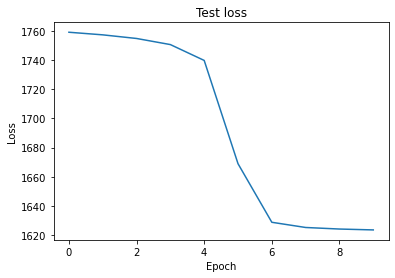

In [41]:
import matplotlib.pyplot as plt

plt.plot(test_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test loss')
plt.show()

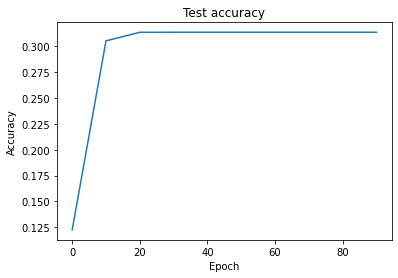

In [47]:
plt.plot(range(0,1000,50),test_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test accuracy')
plt.show()

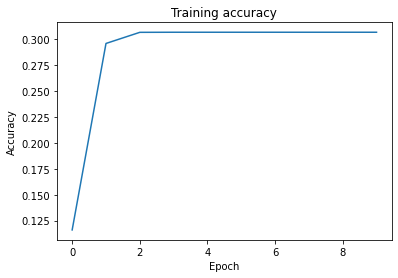

In [43]:
plt.plot(range(0,1000,50), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.show()